In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [59]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers.merge import Multiply
from keras.models import Model
from keras.layers.merge import Concatenate, Add
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D, AveragePooling1D
from keras.regularizers import l2, l1, l1_l2
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.layers.recurrent import LSTM
from keras import backend as K
import tensorflow as tf

In [233]:
def conv_network(input_layer):
    output = Conv1D(64, 8, padding='valid', kernel_regularizer=l2(0.0001))(input_layer)
    output = Activation('relu')(output)
    output = MaxPooling1D(2)(output)
    output = Conv1D(64, 4, padding='valid', kernel_regularizer=l2(0.0001))(output)
    output = Activation('relu')(output)
    output = MaxPooling1D(2)(output)
    output = Flatten()(output)
    #output = Dense(64, kernel_regularizer=l2(0.0001))(output)
    return output

def soft_window(x, c, w, t):
    c = K.reshape(c, (-1, 1))
    w = K.reshape(w, (-1, 1))
    return K.switch(x <= c, 
                    K.sigmoid(t*(x - (c - 0.5*w))),
                    K.sigmoid(t*(-x + (c + 0.5*w))))
    
def direct_cnn(window_size=128, n_channels=4):
    input_layer = Input(shape=(window_size, n_channels))
    output = conv_network(input_layer)
    output = Dense(1)(output)
    output = Activation('sigmoid')(output)
    model = Model(inputs=[input_layer], outputs=[output])
    return model
    
def attention_cnn(window_size=128, n_channels=4, t=10.0):
    def attention_function(params):
        x = np.linspace(-1, 1, window_size).astype(np.float32).reshape((1, window_size))
        c = K.reshape(params, (-1, 1))
        #c = K.reshape(params[:, 0], (-1, 1))
        #w = K.reshape(params[:, 1], (-1, 1))
        #w = K.exp(w)
        w = 10*2.0/window_size
        y = K.switch(x <= c, 
                     K.sigmoid(t*(x - (c - 0.5*w))),
                     K.sigmoid(t*(-x + (c + 0.5*w))))
        y = K.expand_dims(y, axis=-1)
        return y
    
    input_layer = Input(shape=(window_size, n_channels))
    conv_attention = conv_network(input_layer)
    attention_params = Dense(64, name='attention_dense1', activation='relu')(conv_attention)
    attention_params = Dense(64, name='attention_dense2', activation='relu')(attention_params)
    attention_params = Dense(1, name='attention_params')(attention_params)
    attention = Lambda(attention_function, name='attention')(attention_params)
    weighted_input = Multiply(name='multiply_attention')([input_layer, attention])
    conv_predict = conv_network(weighted_input)
    output = Dense(1)(conv_predict)
    output = Activation('sigmoid')(output)
    
    model = Model(inputs=[input_layer], outputs=[output])
    return model, attention_params, attention

#model, attention_params, attention = attention_cnn()
model = direct_cnn()
model.summary()
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 128, 4)            0         
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 121, 64)           2112      
_________________________________________________________________
activation_160 (Activation)  (None, 121, 64)           0         
_________________________________________________________________
max_pooling1d_129 (MaxPoolin (None, 60, 64)            0         
_________________________________________________________________
conv1d_130 (Conv1D)          (None, 57, 64)            16448     
_________________________________________________________________
activation_161 (Activation)  (None, 57, 64)            0         
_________________________________________________________________
max_pooling1d_130 (MaxPoolin (None, 28, 64)            0         
__________

In [276]:
attention_model, attention_params, attention = attention_cnn()
attention_model.summary()
attention_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
attention_model.fit(X, y, batch_size=25, epochs=20)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 128, 4)       0                                            
__________________________________________________________________________________________________
conv1d_139 (Conv1D)             (None, 121, 64)      2112        input_39[0][0]                   
__________________________________________________________________________________________________
activation_174 (Activation)     (None, 121, 64)      0           conv1d_139[0][0]                 
__________________________________________________________________________________________________
max_pooling1d_139 (MaxPooling1D (None, 60, 64)       0           activation_174[0][0]             
__________________________________________________________________________________________________
conv1d_140

In [274]:
attention_model.layers

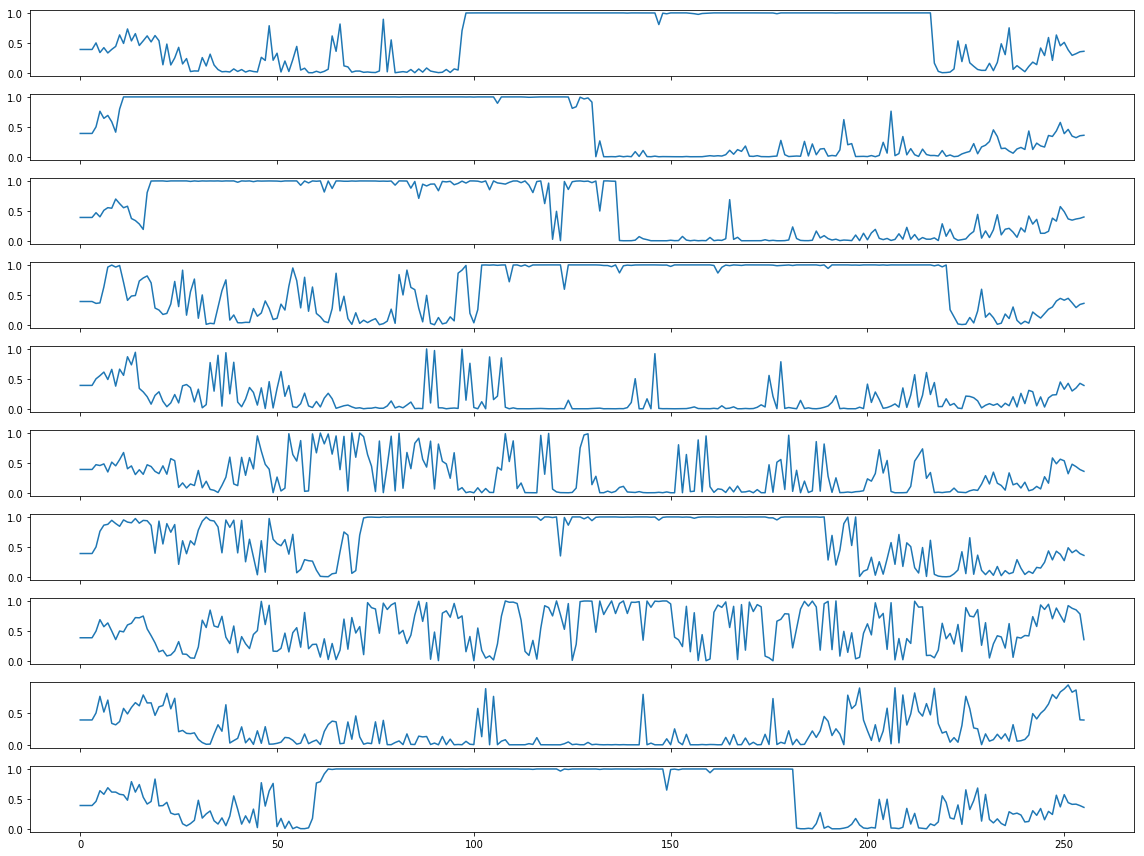

In [265]:
def onehot_encode(s, alphabet='ATCG'):
    alphabet = np.asarray(list(alphabet), dtype='U1')
    x = np.asarray(list(s), dtype='U1')
    encoded = (x[:, np.newaxis] == alphabet[np.newaxis, :]).astype(np.int32)
    return encoded

def onehot_decode(x, alphabet='ATCG'):
    alphabet = np.asarray(list(alphabet), dtype='U1')
    return ''.join(alphabet[np.argmax(x, axis=1)])
    
def scan_sequence(model, sequence, alphabet='ATCG', window_size=128):
    X_seq = np.zeros((window_size*2 + len(sequence), len(alphabet)), dtype=np.float32)
    X_seq[window_size:(window_size + len(sequence))] = onehot_encode(sequence)
    X_win = np.empty((window_size + len(sequence), window_size, len(alphabet)), dtype=np.float32)
    for i in range(window_size + len(sequence)):
        X_win[i] = X_seq[i:(i + window_size)]
    y = model.predict(X_win, batch_size=100)
    return y

fig, axes = plt.subplots(10, 1, figsize=(16, 12), sharex=True)
for i in range(10):
    axes[i].plot(scan_sequence(model, onehot_decode(X[i])))
plt.tight_layout()

In [266]:
positions[:10]

array([88,  2,  8, 68, -1, 34, 69, 22, -1, 53])

In [270]:
from scipy.optimize import leastsq
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

class SoftWindowError(object):
    def __init__(self, X, t=10.0):
        self.X = X
        self.t = t
        
    def func(self, params):
        c, w = params
        t = self.t
        f = np.where(self.X <= c, 
                     sigmoid(t*( self.X - (c - 0.5*w))),
                     sigmoid(t*(-self.X + (c + 0.5*w))))
        return f
    
    def error(self, params):
        return self.func(params) - self.X
    
    def jac(self, params):
        c, w = params
        t = self.t
        f = self.func(params)
        d_f = f*(1 - f)
        d_c = np.where(self.X <= c, -1, 1)
        d_w = np.where(self.X <= c, 0.5, -0.5)
        return np.vstack([2*d_f*d_c, 2*d_f*d_w]).T

soft_window_error = SoftWindowError(X)
soft_window_error.func([1])

In [268]:
np.vstack([np.ones(10), np.zeros(10)])

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [264]:
model.fit(X, y, epochs=10, batch_size=50)

Epoch 1/10
10000/10000 [==============================] - 2s 184us/step - loss: 0.1073 - acc: 0.9802
Epoch 2/10
10000/10000 [==============================] - 2s 179us/step - loss: 0.0976 - acc: 0.9836
Epoch 3/10
10000/10000 [==============================] - 2s 177us/step - loss: 0.0894 - acc: 0.9881
Epoch 4/10
10000/10000 [==============================] - 2s 177us/step - loss: 0.0857 - acc: 0.9902
Epoch 5/10
10000/10000 [==============================] - 2s 178us/step - loss: 0.0768 - acc: 0.9921
Epoch 6/10
10000/10000 [==============================] - 2s 186us/step - loss: 0.0701 - acc: 0.9950
Epoch 7/10
10000/10000 [==============================] - 2s 191us/step - loss: 0.0659 - acc: 0.9973
Epoch 8/10
10000/10000 [==============================] - 2s 184us/step - loss: 0.0644 - acc: 0.9957
Epoch 9/10
10000/10000 [==============================] - 2s 180us/step - loss: 0.0565 - acc: 0.9990
Epoch 10/10
10000/10000 [==============================] - 2s 179us/step - loss: 0.0531 - a

In [236]:
model

In [273]:
calc_attention_params = K.function([attention_model.input], [attention_params])
calc_attention = K.function([attention_model.input], [attention])

attention_params_values = calc_attention_params([X[:100]])[0]
attention_values = calc_attention([X[:10]])[0]

fig, axes = plt.subplots(10, 1, figsize=(10, 10), sharex=True)
for i in range(10):
    axes[i].plot(attention_values[i])
plt.tight_layout()

InvalidArgumentError: You must feed a value for placeholder tensor 'input_32' with dtype float and shape [?,128,4]
	 [[Node: input_32 = Placeholder[dtype=DT_FLOAT, shape=[?,128,4], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'input_32', defined at:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/opt/conda/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/opt/conda/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-229-81936a0b379c>", line 47, in <module>
    model, attention_params, attention = attention_cnn()
  File "<ipython-input-229-81936a0b379c>", line 33, in attention_cnn
    input_layer = Input(shape=(window_size, n_channels))
  File "/opt/conda/lib/python3.6/site-packages/keras/engine/topology.py", line 1457, in Input
    input_tensor=tensor)
  File "/opt/conda/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/keras/engine/topology.py", line 1366, in __init__
    name=self.name)
  File "/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 507, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1746, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3051, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_32' with dtype float and shape [?,128,4]
	 [[Node: input_32 = Placeholder[dtype=DT_FLOAT, shape=[?,128,4], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [179]:
positions[:100]

array([11, -1, -1, 34, -1, 12, 54,  9, -1, 29, 52, 34, 39,  3, -1, -1,  0,
       -1, -1, 54, 15,  2, 30, 36, -1, -1, 17, 35, -1, 15, -1, 21,  2, 56,
       -1, 51, -1, 52, 51,  9, -1, 52, -1, 45, -1,  4, 24, -1, 23, -1, -1,
       -1,  7, -1, -1, 27, -1, 35, 53, 15, -1, -1, -1,  2, 55, -1, 51,  8,
       -1, 48, 47, 14, -1, -1, 56, -1, -1, -1, -1, -1, -1, -1, -1, 24, -1,
       -1, -1, -1, 31, -1, -1, 41, -1,  4,  5, 44, -1,  4, 23, -1])

In [143]:
y.h

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [261]:
class Motif(object):
    def __init__(self, length=3, alphabet='ATCG'):
        self.length = length
        self.alphabet = np.asarray(list(alphabet), dtype='U1')
        self.pwm = np.exp(np.random.uniform(size=(len(alphabet), length))*10.0)
        self.pwm /= np.sum(self.pwm, axis=0, keepdims=True)
        self.cumpwm = np.cumsum(self.pwm, axis=0)
        self.cumpwm[-1, :] += 0.1
        self.consensus = ''.join(self.alphabet[np.argmax(self.pwm, axis=0)])
    
    def print_pwm(self):
        print('\t'.join(list(self.alphabet)))
        for i in range(self.length):
            print('\t'.join(['%.6f'%a for a in self.pwm[:, i]]))
            
    def sample(self, length, size=1):
        assert length >= self.length
        X = np.random.randint(len(self.alphabet), size=(size, length))
        p = np.random.uniform(size=(size, len(self.alphabet), self.length))
        motifs = np.argmax(p < self.cumpwm[np.newaxis, :, :], axis=1)
        positions = np.random.randint(length - self.length + 1, size=size)
        for i in range(size):
            X[i, positions[i]:(positions[i] + self.length)] = motifs[i]
        X = (X[:, :, np.newaxis] == np.arange(len(self.alphabet))[np.newaxis, np.newaxis, :]).astype(np.float32)
        #sequences = [''.join(a) for a in np.take(self.alphabet, X)]
        return X, positions

    def sample_negative(self, length, size=1):
        X = np.random.randint(len(self.alphabet), size=(size, length))
        X = (X[:, :, np.newaxis] == np.arange(len(self.alphabet))[np.newaxis, np.newaxis, :]).astype(np.float32)
        return X

motif = Motif(length=8)
print('consensus: ', motif.consensus)
print('PWM: ')
motif.print_pwm()
n_samples = 5000
X_pos, positions = motif.sample(length=128, size=n_samples)
X_neg = motif.sample_negative(length=128, size=n_samples)
X = np.concatenate([X_pos, X_neg], axis=0)
y = np.concatenate([np.ones(n_samples), np.zeros(n_samples)])
positions = np.concatenate([positions, np.full(n_samples, -1)])
random_indices = np.random.permutation(X.shape[0])
X = X[random_indices]
y = y[random_indices]
positions = positions[random_indices]
#for sequence, position in zip(*motif.sample(length=20, size=10)):
    #print(position, sequence)
#ax.pcolor(motif.pwm, cmap=cm.RdBu_r)
#fig, ax = plt.subplots(figsize=(8, 3))
#ax.pcolor(np.swapaxes(X, 1, 2).reshape((-1, 20)), cmap=cm.Greys)

consensus:  TCGTTATC
PWM: 
A	T	C	G
0.003547	0.686415	0.086452	0.223587
0.009957	0.001894	0.987850	0.000299
0.010541	0.024267	0.001532	0.963660
0.007188	0.734368	0.258126	0.000318
0.413579	0.502202	0.083014	0.001205
0.910990	0.038770	0.013744	0.036496
0.419574	0.576429	0.002846	0.001151
0.000318	0.001062	0.996720	0.001900


In [225]:
positions[:100]

array([ -1,  37,  -1,  -1,  88, 102,   8,  -1,  -1,  -1,   5,  -1,  -1,
        23,  81, 102, 114,  -1,  38, 112,  -1,  40,  -1,  -1,  49,  -1,
        23, 110,  18,  -1,  47,  -1,  47, 106,  93,   5,  -1,  -1,  28,
        29,  91,  -1, 111,  92,  -1, 120, 106,  62,  -1,  -1,   3,  88,
        80,   1,  50,  14,  -1,  30,  -1,  -1,  -1,  -1, 106,  74,  28,
        -1,  -1, 114,  85,  85,  15,  15,  53,  -1,  51,  78,  -1,  -1,
        -1,  -1,  29,  -1,  -1,  -1,  56,  -1,  46,  26,  -1,  -1,  70,
        -1,  80,  -1,  76,   7,  -1, 111,  -1,  55])

In [101]:
def tf_window_function(x, c, w, t):
    c = K.reshape(c, (-1, 1))
    w = K.reshape(w, (-1, 1))
    return K.switch(x <= c, 
                    K.sigmoid(t*(x - (c - 0.5*w))),
                    K.sigmoid(t*(-x + (c + 0.5*w))))

def merge_model(window_size, parat,
                n_channels=4, weight_channels =1,
                regression=False, dense=False):
    A1 = keras.layers.Input(shape=(window_size,n_channels),name='A1')
    A2 = Conv1D(64, 7, padding='valid',kernel_regularizer=l2(0.0001),name="A2")(A1)
    A3 = Activation('relu',name="A3")(A2)
    A4 = MaxPooling1D(2,name="A4")(A3)
    A5 = Conv1D(64, 3, padding='valid', kernel_regularizer=l2(0.0001),name="A5")(A4)
    A6 = Activation('relu',name="A6")(A5)
    A7 = MaxPooling1D(2,name="A7")(A6)
    A8 = Conv1D(64, 3, padding='valid', kernel_regularizer=l2(0.0001),name="A8")(A7)
    A9 = Activation('relu',name="A9")(A8)
    A10 = MaxPooling1D(2,name="A10")(A9)
    A11 = Flatten(name="A11")(A10)
    A12 = Dense(window_size, kernel_regularizer=l2(0.0001),name="A12")(A11)
    A13 = Activation('relu',name="A13")(A12)
    
    A14 = Dense(2, kernel_regularizer=l2(0.0001),name="A14")(A13)
    A15 = Activation('relu',name="A15")(A14)
    
    rangenum = np.linspace(0, 1, window_size).reshape((1, window_size)).astype(np.float32)
    funcwindow = Lambda(lambda x: tf_window_function(rangenum, x[:, 0], x[:, 1], parat),
                       output_shape=(window_size,),name='functionwindow')(A15)
    
    output_size = window_size if dense else 1 
    multiple = Multiply()([A13, funcwindow])
    if not regression:
        out = Dense(output_size, activation ='sigmoid',name='out')(multiple)
    model = Model(inputs=[A1], outputs=[out])
    loss = 'binary_crossentropy'
    metrics = ['accuracy']
    
    model.compile(optimizer='Adam',loss=loss,metrics=metrics)
    return model, funcwindow, A15

model, funcwindow, A15 = merge_model(64, 10)
model.summary()

NameError: name 'window_params' is not defined

In [99]:
model.fit(X, y, batch_size=25)

Epoch 1/1
10000/10000 [==============================] - 3s 295us/step - loss: 0.0241 - acc: 1.0000


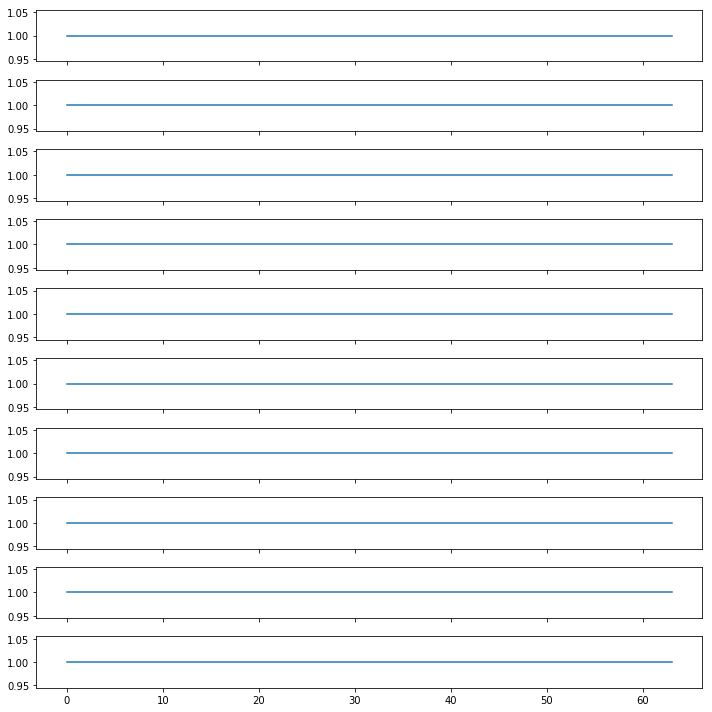

In [100]:
calc_weights = K.function([model.input], [funcwindow])
weights = calc_weights([X[:100]])[0]
fig, axes = plt.subplots(10, 1, figsize=(10, 10), sharex=True)
for i in range(10):
    axes[i].plot(weights[i])
plt.tight_layout()